--- 🎬 Full Test Started: API Keys -> Image -> Audio -> Video ---
[1/6] 환경 변수 로드 중...
[2/6] Google Imagen으로 이미지 생성 중... (프롬프트: A cute hamster chef ...)
  > 임시 이미지 저장 완료: outputs/temp_image_for_video_20251110_165021.jpeg


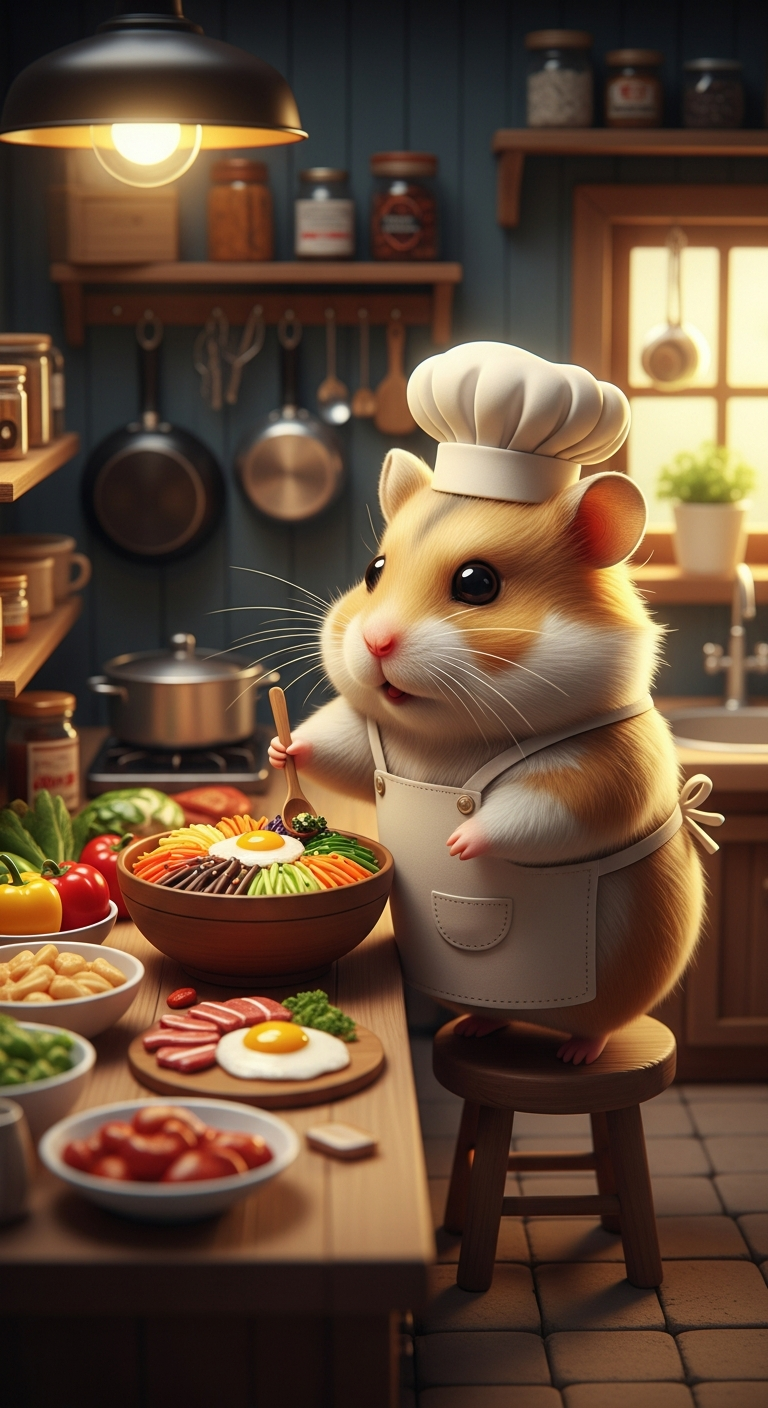

[3/6] OpenAI TTS로 오디오 생성 중... (텍스트: 오늘은 맛있는 햄스터 비빔밥을 만들어...)
  > 임시 오디오 저장 완료: outputs/temp_audio_for_video_20251110_165021.mp3


[4/6] FFmpeg로 'outputs/final_video_20251110_165021.mp4' 파일 생성 중...
✅ [5/6] 테스트 성공! 최종 비디오가 'outputs/final_video_20251110_165021.mp4'에 저장되었습니다.



[6/6] 임시 파일 정리 중...
  > 삭제: outputs/temp_image_for_video_20251110_165021.jpeg
  > 삭제: outputs/temp_audio_for_video_20251110_165021.mp3
--- 🎬 Full Test Finished ---


In [3]:
import os
import io
import datetime
import requests
import base64
import subprocess
import google.genai as genai
import openai
from PIL import Image
from IPython.display import display, Video, Audio
from dotenv import load_dotenv

print("--- 🎬 Full Test Started: API Keys -> Image -> Audio -> Video ---")

# --- 1. 환경 설정 (API 키, 폴더, 타임스탬프) ---
print("[1/6] 환경 변수 로드 중...")
load_dotenv()

GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

if not GOOGLE_API_KEY or not OPENAI_API_KEY:
    raise ValueError("GOOGLE_API_KEY 또는 OPENAI_API_KEY가 .env 파일에 없습니다.")

# 생성된 파일을 저장할 'outputs' 폴더 생성
os.makedirs("outputs", exist_ok=True)

def get_timestamp():
    return datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# --- 2. 변수 정의 ---
IMAGE_PROMPT = "A cute hamster chef in a tiny kitchen, cooking bibimbap, 9:16 aspect ratio, digital art"
NARRATION_TEXT = "오늘은 맛있는 햄스터 비빔밥을 만들어 볼까요?"
VOICE_ID = "nova"

# 임시 파일 및 최종 파일 경로
temp_image_path = f"outputs/temp_image_for_video_{get_timestamp()}.jpeg"
temp_audio_path = f"outputs/temp_audio_for_video_{get_timestamp()}.mp3"
output_video_path = f"outputs/final_video_{get_timestamp()}.mp4"

# API 클라이언트 초기화
google_client = genai.Client(api_key=GOOGLE_API_KEY)
openai_client = openai.OpenAI(api_key=OPENAI_API_KEY)

try:
    # --- 3. Google Imagen으로 이미지 생성 ---
    print(f"[2/6] Google Imagen으로 이미지 생성 중... (프롬프트: {IMAGE_PROMPT[:20]}...)")
    response_img = google_client.models.generate_images(
        model='imagen-4.0-generate-001',
        prompt=IMAGE_PROMPT,
        config=genai.types.GenerateImagesConfig(
            number_of_images=1,
            aspect_ratio="9:16",
        )
    )
    # 검증 완료된 바이트 추출 경로
    image_bytes = response_img.generated_images[0].image.image_bytes
    if not image_bytes:
        raise Exception("Google Imagen이 이미지를 반환하지 않았습니다.")
        
    img = Image.open(io.BytesIO(image_bytes))
    img.save(temp_image_path, format="JPEG")
    print(f"  > 임시 이미지 저장 완료: {temp_image_path}")
    display(img)

    # --- 4. OpenAI TTS로 오디오 생성 ---
    print(f"[3/6] OpenAI TTS로 오디오 생성 중... (텍스트: {NARRATION_TEXT[:20]}...)")
    with openai_client.audio.speech.with_streaming_response.create(
        model="gpt-4o-mini-tts",
        voice=VOICE_ID,
        input=NARRATION_TEXT
    ) as response_audio:
        audio_data = response_audio.read()
    
    with open(temp_audio_path, "wb") as f:
        f.write(audio_data)
    print(f"  > 임시 오디오 저장 완료: {temp_audio_path}")
    display(Audio(temp_audio_path))

    # --- 5. FFmpeg로 비디오 합성 ---
    print(f"[4/6] FFmpeg로 '{output_video_path}' 파일 생성 중...")
    
    ffmpeg_cmd = [
        "ffmpeg",
        "-loop", "1",           # 이미지를 무한 루프
        "-i", temp_image_path,  # 비디오 입력 (이미지)
        "-i", temp_audio_path,  # 오디오 입력
        "-c:v", "libx264",      # 비디오 코덱
        "-c:a", "aac",          # 오디오 코덱
        "-pix_fmt", "yuv420p",  # 픽셀 포맷 (호환성)
        "-shortest",            # 오디오 길이에 맞춰 종료
        output_video_path
    ]
    
    subprocess.run(ffmpeg_cmd, check=True, capture_output=True, text=True)
    
    print(f"✅ [5/6] 테스트 성공! 최종 비디오가 '{output_video_path}'에 저장되었습니다.")
    
    # 노트북에 최종 비디오 출력
    display(Video(output_video_path, embed=True, width=360))

except FileNotFoundError as e:
    print(f"❌ 테스트 실패: [WinError 2] 'ffmpeg'를 찾을 수 없습니다.")
    print("   'winget install \"FFmpeg (Gyan.dev)\"'로 설치하고, **터미널과 VS Code(Jupyter)를 완전히 재시작**하세요.")
except subprocess.CalledProcessError as e:
    print(f"❌ 테스트 실패: FFmpeg 실행 중 오류가 발생했습니다.")
    print("   FFmpeg는 'ffmpeg'를 찾았으나, 명령어 실행 중 오류가 발생했습니다.")
    print(f"   [FFmpeg Stderr]: {e.stderr}")
except Exception as e:
    print(f"❌ 테스트 실패 (API 또는 기타 오류): {e}")

finally:
    # --- 6. 임시 파일 정리 ---
    print(f"\n[6/6] 임시 파일 정리 중...")
    if os.path.exists(temp_image_path):
        os.remove(temp_image_path)
        print(f"  > 삭제: {temp_image_path}")
    if os.path.exists(temp_audio_path):
        os.remove(temp_audio_path)
        print(f"  > 삭제: {temp_audio_path}")
        
print("--- 🎬 Full Test Finished ---")